In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face
best_vitpose_model			  output
datasets				  RTDETR_Huggingface_det_train.ipynb
Detectron2_MaskRCNN_Seg.ipynb		  SegFormer_Huggingface_seg_train.ipynb
EfficientNet_classify.ipynb		  segformer_trained_weights
markerpensseg				  segformer_trained_weights_47
Markerpens_seg				  ViT_Huggingface_classify.ipynb
mask2former_Huggingface_seg.ipynb	  vit-multilabel-best
mask2formerresults			  ViTPose_Huggingface_keypoints.ipynb
MMDetection_MaskRCNN_PointRend_Seg.ipynb  YOLOS_Huggingface_det.ipynb
mydrive					  YOLOS_Huggingface_det_wandb.ipynb


In [2]:
import torch
import os

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


Setup complete. Using torch 2.6.0+cu124 (Tesla T4)


In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random
import json
import numpy as np
from collections import defaultdict

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [14]:
# Paths to your dataset
root_dir = Path("datasets/sisdet")
train_json = root_dir / "train_clean_updated.json"
val_json = root_dir / "val_clean_updated.json"
train_img_dir = root_dir / "train"
val_img_dir = root_dir / "valid"

# Class map (COCO category_id -> index)
label_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
class_names = ["G", "HA", "IS", "M", "NH"]
num_classes = len(label_map)

In [15]:
class CocoMultiLabelDataset(Dataset):
    def __init__(self, json_path, image_dir, transform, label_map):
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.label_map = label_map

        with open(json_path) as f:
            data = json.load(f)

        self.id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}
        self.imgid_to_cats = defaultdict(set)
        for ann in data["annotations"]:
            self.imgid_to_cats[ann["image_id"]].add(label_map[ann["category_id"]])

        self.data = []
        for img_id, cat_indices in self.imgid_to_cats.items():
            file_path = self.image_dir / self.id_to_filename[img_id]
            label_vector = np.zeros(len(label_map), dtype=np.float32)
            for idx in cat_indices:
                label_vector[idx] = 1.0
            self.data.append((file_path, label_vector))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [17]:
transform = transforms.Compose([
    transforms.Resize(300),       # B3 expects 300x300 input
    transforms.CenterCrop(300),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [18]:
# Load training and validation datasets
train_dataset = CocoMultiLabelDataset(
    json_path=train_json,
    image_dir=train_img_dir,
    transform=transform,
    label_map=label_map
)

val_dataset = CocoMultiLabelDataset(
    json_path=val_json,
    image_dir=val_img_dir,
    transform=transform,
    label_map=label_map
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet-B3 and modify for multi-label classification
model = models.efficientnet_b3(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [24]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import os

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    y_true = np.vstack(all_labels)
    y_pred = np.vstack(all_outputs)

    # Binary F1 (per sample, then averaged macro)
    f1 = f1_score(y_true, y_pred > 0.5, average="macro", zero_division=0)
    return avg_loss, f1, y_true, y_pred

In [25]:
best_f1 = 0
num_epochs = 30
save_path = "datasets/efficientnet_b3_multilabel_best.pth"

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_f1, y_true, y_pred = validate(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), save_path)
        print("✅ Best model saved.")

    scheduler.step()  # optional


Epoch 1/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Train Loss: 0.6082 | Val Loss: 0.5497 | Val F1: 0.1352
✅ Best model saved.

Epoch 2/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 0.4578 | Val Loss: 0.4536 | Val F1: 0.3537
✅ Best model saved.

Epoch 3/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Train Loss: 0.3243 | Val Loss: 0.3515 | Val F1: 0.6761
✅ Best model saved.

Epoch 4/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Train Loss: 0.2175 | Val Loss: 0.3129 | Val F1: 0.7628
✅ Best model saved.

Epoch 5/30


Validating: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Train Loss: 0.1533 | Val Loss: 0.2770 | Val F1: 0.7851
✅ Best model saved.

Epoch 6/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Train Loss: 0.1076 | Val Loss: 0.2769 | Val F1: 0.7782

Epoch 7/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


Train Loss: 0.0760 | Val Loss: 0.2732 | Val F1: 0.7907
✅ Best model saved.

Epoch 8/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Train Loss: 0.0644 | Val Loss: 0.2657 | Val F1: 0.8114
✅ Best model saved.

Epoch 9/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Train Loss: 0.0465 | Val Loss: 0.2672 | Val F1: 0.8083

Epoch 10/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Train Loss: 0.0326 | Val Loss: 0.2648 | Val F1: 0.8163
✅ Best model saved.

Epoch 11/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Train Loss: 0.0267 | Val Loss: 0.2773 | Val F1: 0.8045

Epoch 12/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Train Loss: 0.0233 | Val Loss: 0.2658 | Val F1: 0.8190
✅ Best model saved.

Epoch 13/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Train Loss: 0.0240 | Val Loss: 0.2624 | Val F1: 0.8283
✅ Best model saved.

Epoch 14/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Train Loss: 0.0207 | Val Loss: 0.2653 | Val F1: 0.8285
✅ Best model saved.

Epoch 15/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Train Loss: 0.0220 | Val Loss: 0.2863 | Val F1: 0.8237

Epoch 16/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Train Loss: 0.0199 | Val Loss: 0.2761 | Val F1: 0.8251

Epoch 17/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Train Loss: 0.0126 | Val Loss: 0.2845 | Val F1: 0.8215

Epoch 18/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Train Loss: 0.0127 | Val Loss: 0.3024 | Val F1: 0.8184

Epoch 19/30


Validating: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Train Loss: 0.0126 | Val Loss: 0.2977 | Val F1: 0.8189

Epoch 20/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Train Loss: 0.0124 | Val Loss: 0.2931 | Val F1: 0.8175

Epoch 21/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Train Loss: 0.0108 | Val Loss: 0.3095 | Val F1: 0.8168

Epoch 22/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Train Loss: 0.0105 | Val Loss: 0.3011 | Val F1: 0.8200

Epoch 23/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Train Loss: 0.0113 | Val Loss: 0.2988 | Val F1: 0.8214

Epoch 24/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Train Loss: 0.0104 | Val Loss: 0.2934 | Val F1: 0.8245

Epoch 25/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Train Loss: 0.0077 | Val Loss: 0.2971 | Val F1: 0.8227

Epoch 26/30


Validating: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Train Loss: 0.0091 | Val Loss: 0.2936 | Val F1: 0.8274

Epoch 27/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Train Loss: 0.0104 | Val Loss: 0.3022 | Val F1: 0.8224

Epoch 28/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


Train Loss: 0.0099 | Val Loss: 0.2921 | Val F1: 0.8268

Epoch 29/30


Validating: 100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Train Loss: 0.0101 | Val Loss: 0.2974 | Val F1: 0.8217

Epoch 30/30


Validating: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]

Train Loss: 0.0083 | Val Loss: 0.3124 | Val F1: 0.8248


In [26]:
# Redefine the model structure
model = models.efficientnet_b3(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load("datasets/efficientnet_b3_multilabel_best.pth", map_location=device))
model = model.to(device).eval()

true_labels_all = []
pred_probs_all = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Eval"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()

        true_labels_all.append(labels.numpy())
        pred_probs_all.append(probs)

true_labels_all = np.concatenate(true_labels_all, axis=0)
pred_probs_all = np.concatenate(pred_probs_all, axis=0)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Final Eval: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


In [27]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_thresholds(true_labels_all, pred_probs_all, class_names, step=0.05):
    num_classes = len(class_names)
    best_thresholds = []

    for i in range(num_classes):
        best_f1 = 0
        best_thresh = 0.5  # default
        y_true = true_labels_all[:, i]
        y_scores = pred_probs_all[:, i]

        for thresh in np.arange(0.1, 0.91, step):
            y_pred = (y_scores > thresh).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        print(f"Class {i} ({class_names[i]}): Best Threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")

    return best_thresholds

In [29]:
best_thresholds = find_best_thresholds(true_labels_all, pred_probs_all, class_names)
print("Best thresholds:", best_thresholds)

Class 0 (G): Best Threshold = 0.45, F1 = 0.7983
Class 1 (HA): Best Threshold = 0.60, F1 = 0.7480
Class 2 (IS): Best Threshold = 0.40, F1 = 0.7789
Class 3 (M): Best Threshold = 0.15, F1 = 0.9703
Class 4 (NH): Best Threshold = 0.50, F1 = 0.8864
Best thresholds: [np.float64(0.45000000000000007), np.float64(0.6000000000000002), np.float64(0.40000000000000013), np.float64(0.15000000000000002), np.float64(0.5000000000000001)]


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_per_class_metrics(y_true, y_probs, thresholds, class_names):
    y_pred = (y_probs > thresholds).astype(int)

    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
    print("-" * 40)
    for i, name in enumerate(class_names):
        print(f"{name:<10} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f}")

    return precision, recall, f1

In [31]:
thresholds_array = np.array(best_thresholds)
precision, recall, f1 = evaluate_per_class_metrics(
    y_true=true_labels_all,
    y_probs=pred_probs_all,
    thresholds=thresholds_array,
    class_names=class_names
)

Class      Precision  Recall     F1        
----------------------------------------
G          0.8051     0.7917     0.7983    
HA         0.7797     0.7188     0.7480    
IS         0.8222     0.7400     0.7789    
M          0.9800     0.9608     0.9703    
NH         0.9750     0.8125     0.8864    


In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_per_class_metrics(precision, recall, f1, class_names):
    x = np.arange(len(class_names))
    width = 0.25  # width of the bars

    plt.figure(figsize=(7, 5))
    plt.bar(x - width, precision, width, label='Precision', color='skyblue')
    plt.bar(x, recall, width, label='Recall', color='lightgreen')
    plt.bar(x + width, f1, width, label='F1 Score', color='salmon')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Per-Class Precision, Recall, and F1 Score')
    plt.xticks(x, class_names)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

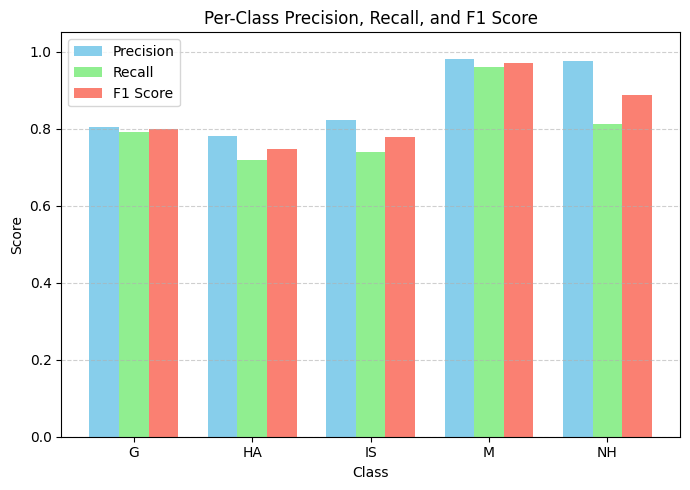

In [60]:
plot_per_class_metrics(precision, recall, f1, class_names)

In [75]:
def predict(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    return probs, image

def visualize_predictions(val_dataset, model, transform, class_names, thresholds, n_images=12, cols=3, device="cpu"):
    # ===== Build a class-wise index mapping =====
    class_to_indices = defaultdict(list)
    for idx, (img_path, label_vec) in enumerate(val_dataset.data):
        for class_id, val in enumerate(label_vec):
            if val == 1:
                class_to_indices[class_id].append(idx)

    # ===== Sample images across all classes =====
    selected_indices = set()
    max_per_class = max(1, n_images // len(class_names))
    for class_id, indices in class_to_indices.items():
        random.shuffle(indices)
        count = 0
        for idx in indices:
            if idx not in selected_indices:
                selected_indices.add(idx)
                count += 1
            if count >= max_per_class:
                break

    # Fill up remaining
    remaining = n_images - len(selected_indices)
    if remaining > 0:
        all_indices = list(set(range(len(val_dataset))) - selected_indices)
        random.shuffle(all_indices)
        selected_indices.update(all_indices[:remaining])

    selected = list(selected_indices)[:n_images]

    # ===== Plotting =====
    rows = (n_images + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 2))
    axs = axs.flatten()

    for i, idx in enumerate(selected):
        img_path, true_label = val_dataset.data[idx]
        probs, image = predict(img_path, model, transform, device)

        pred_labels = [class_names[j] for j, p in enumerate(probs) if p > thresholds[j]]
        true_labels = [class_names[j] for j, v in enumerate(true_label) if v == 1]

        # Convert PIL to OpenCV image (for cv2 text)
        image_np = np.array(image)
        image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

        # Draw texts
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 3
        thickness = 12

        pred_text = "Predicted: " + (", ".join(pred_labels) if pred_labels else "None")
        cv2.putText(image_bgr, pred_text, (105, 125), font, font_scale, (255, 255, 0), thickness, cv2.LINE_AA)

        true_text = "GroundTruth: " + (", ".join(true_labels) if true_labels else "None")
        cv2.putText(image_bgr, true_text, (105, 225), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        axs[i].imshow(image_rgb)
        axs[i].axis("off")

    for j in range(n_images, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

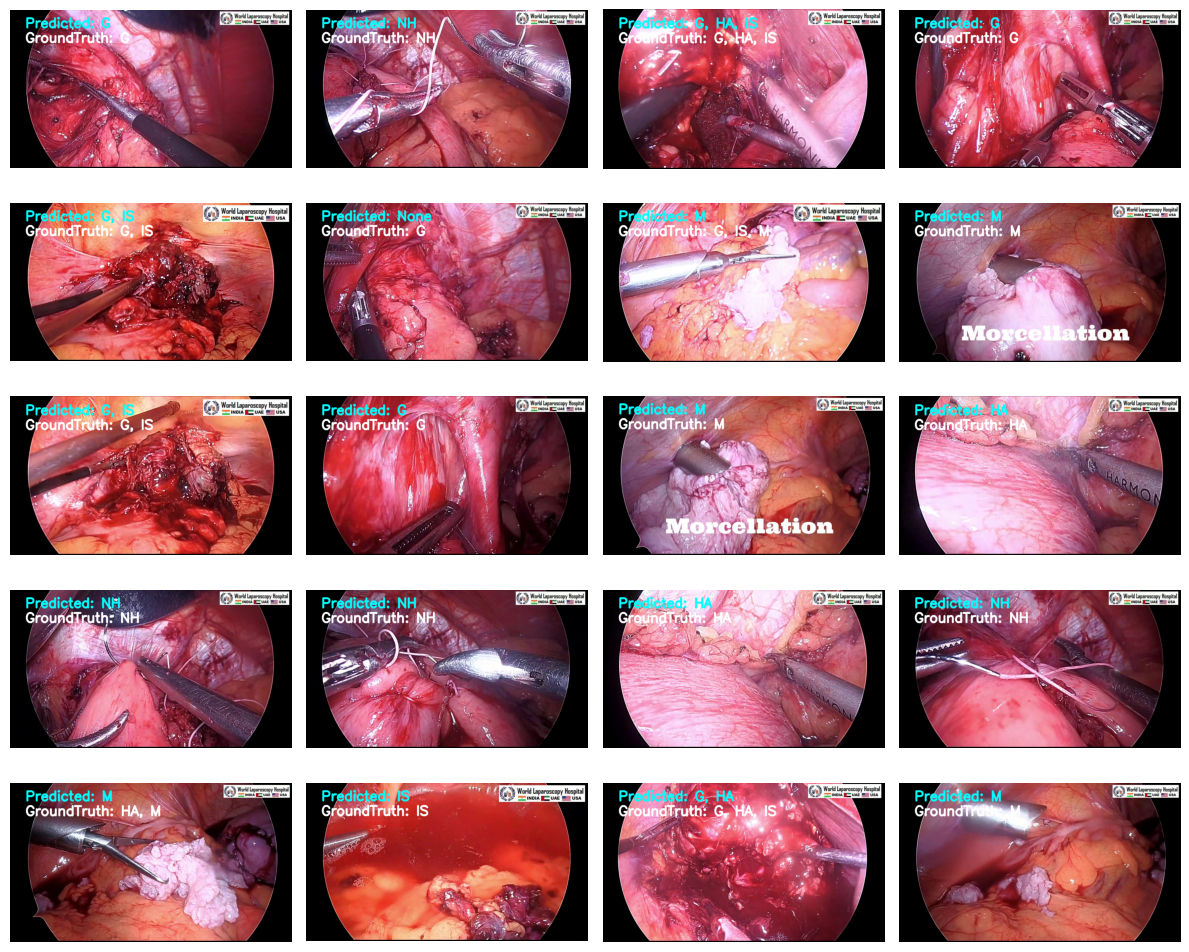

In [81]:
visualize_predictions(
    val_dataset=val_dataset,
    model=model,
    transform=transform,
    class_names=class_names,
    thresholds=best_thresholds,
    n_images=20,
    cols=4,
    device=device
)